In [1]:
CUDA_INDEX = 0
NAME = 'CiteSeer'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [5]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [7]:
def range_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    r = torch.arange(1, int(torch.max(lb).item()), 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(r, lb, ub, pred)
        viz.plot_summary(r, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('range')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = utils.nanmean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
#         print()

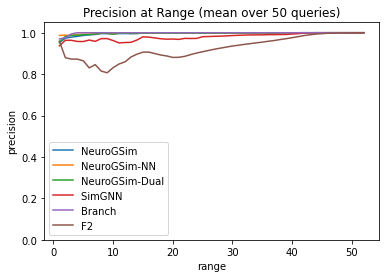

95.23 / 97.87 / 98.96 / 99.56 / 99.57
98.69 / 98.68 / 99.30 / 99.79 / 99.83
95.55 / 98.71 / 99.11 / 99.78 / 99.77
93.65 / 96.33 / 96.46 / 97.14 / 95.05
96.96 / 99.42 / 99.99 / 100.00 / 99.93
95.89 / 87.28 / 83.02 / 81.47 / 84.89


In [7]:
range_metrics(metrics.precision_at_range, lb, ub, preds,
              'precision', f'Precision at Range (mean over {len(queries)} queries)')

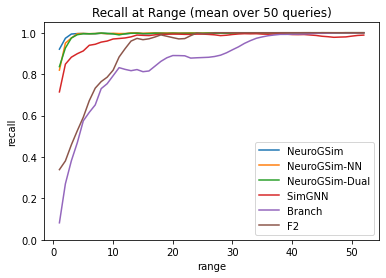

92.05 / 99.36 / 99.48 / 99.74 / 99.44
81.94 / 97.43 / 99.54 / 99.73 / 99.59
83.63 / 97.44 / 99.49 / 99.83 / 98.95
71.42 / 88.18 / 93.93 / 95.46 / 97.20
8.21 / 38.14 / 61.54 / 73.00 / 83.13
33.88 / 45.86 / 67.15 / 76.41 / 88.27


In [8]:
range_metrics(metrics.recall_at_range, lb, ub, preds,
              'recall', f'Recall at Range (mean over {len(queries)} queries)')

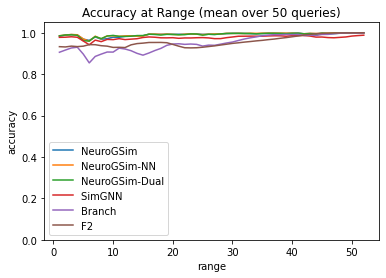

98.27 / 99.09 / 96.28 / 96.85 / 97.79
98.54 / 99.15 / 95.91 / 97.02 / 98.27
98.50 / 99.00 / 95.97 / 97.16 / 98.24
97.76 / 98.04 / 94.20 / 95.69 / 97.13
90.56 / 92.63 / 85.43 / 89.67 / 92.55
93.26 / 93.53 / 94.24 / 93.73 / 92.95


In [9]:
range_metrics(metrics.accuracy_at_range, lb, ub, preds,
              'accuracy', f'Accuracy at Range (mean over {len(queries)} queries)')

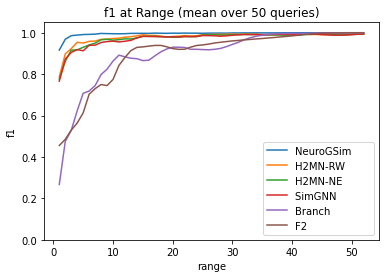

91.60 / 98.57 / 99.19 / 99.65 / 99.48
78.67 / 92.31 / 95.85 / 96.80 / 97.34
77.64 / 91.58 / 94.08 / 96.59 / 96.63
76.62 / 90.48 / 93.93 / 95.28 / 95.55
26.72 / 52.83 / 71.84 / 79.81 / 89.17
45.55 / 52.95 / 70.29 / 74.99 / 84.25


In [8]:
range_metrics(metrics.f1_at_range, lb, ub, preds,
              'f1', f'f1 at Range (mean over {len(queries)} queries)')

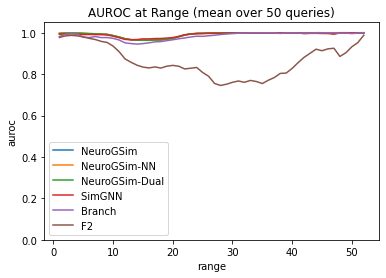

99.60 / 99.79 / 99.50 / 99.34 / 97.91
99.79 / 99.86 / 99.62 / 99.38 / 97.92
99.60 / 99.82 / 99.54 / 99.36 / 97.91
99.25 / 99.49 / 99.15 / 99.04 / 97.57
98.17 / 99.55 / 97.70 / 97.64 / 96.49
97.71 / 98.72 / 97.29 / 95.82 / 90.84


In [11]:
range_metrics(metrics.auroc_at_range, lb, ub, preds,
              'auroc', f'AUROC at Range (mean over {len(queries)} queries)')

# 